### Laboratorium 4 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [18]:
!pip install scikit-image

In [19]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic

#### Zadanie 1

Dane są obrazy `hare` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie jednolitych  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja `mark_boundaries`.

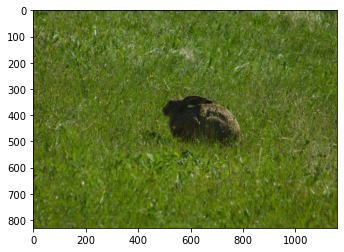

In [20]:
hare = cv2.imread('dane/Zajac_kolor.jpg')[..., ::-1]
plt.imshow(hare);

In [21]:
def draw_test_segments(img):
    f, axs = plt.subplots(3, 3, figsize=(20, 20))

    for row, numSegments in zip(axs, (100, 300, 600)):
        for ax, sigma in zip(row, (0.1, 1, 5)):
            segments = slic(img, n_segments=numSegments, sigma=sigma, start_label=1)
            img_segmented = mark_boundaries(img, segments)
            ax.imshow(img_segmented) 
            ax.axis("off")
            ax.set_title(f'{numSegments} Segments, {sigma} Sigma')
    plt.tight_layout()
    plt.show()

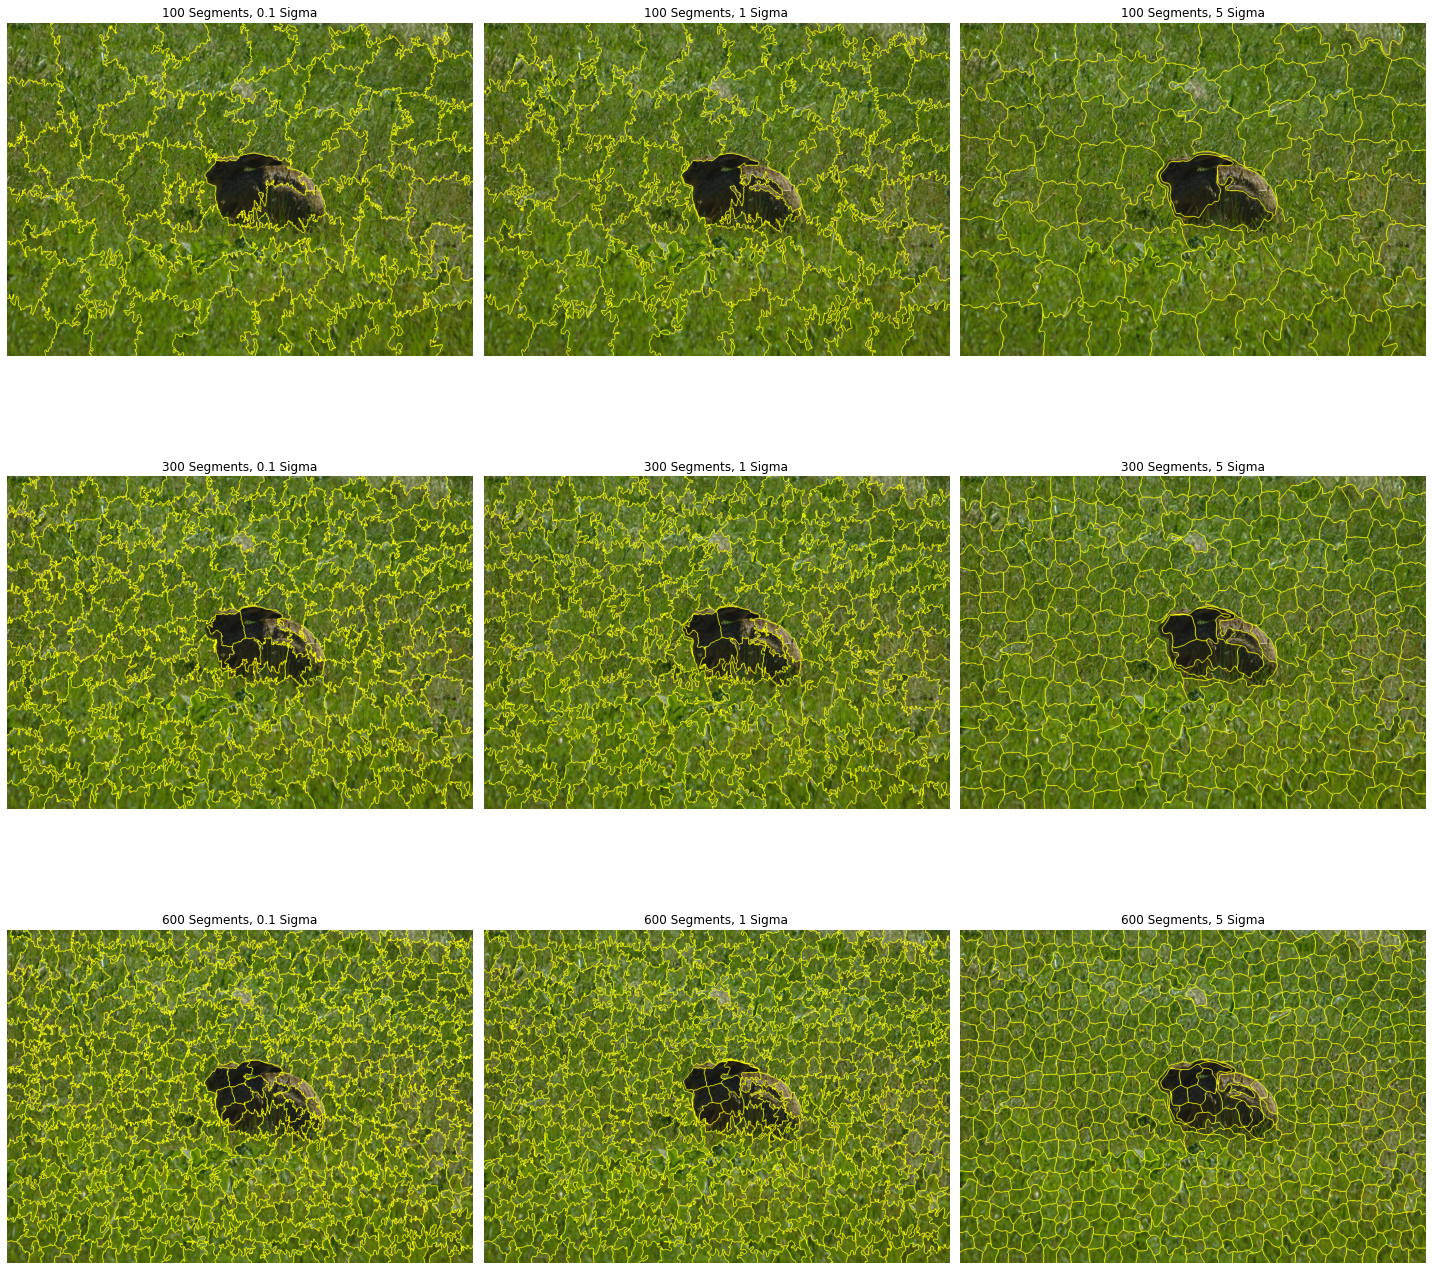

In [22]:
draw_test_segments(hare)

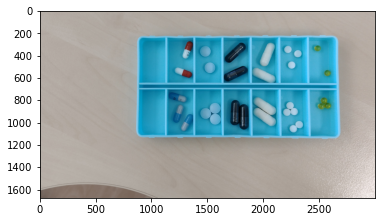

In [23]:
pills = cv2.imread('dane/pills.png')[..., ::-1]
plt.imshow(pills);

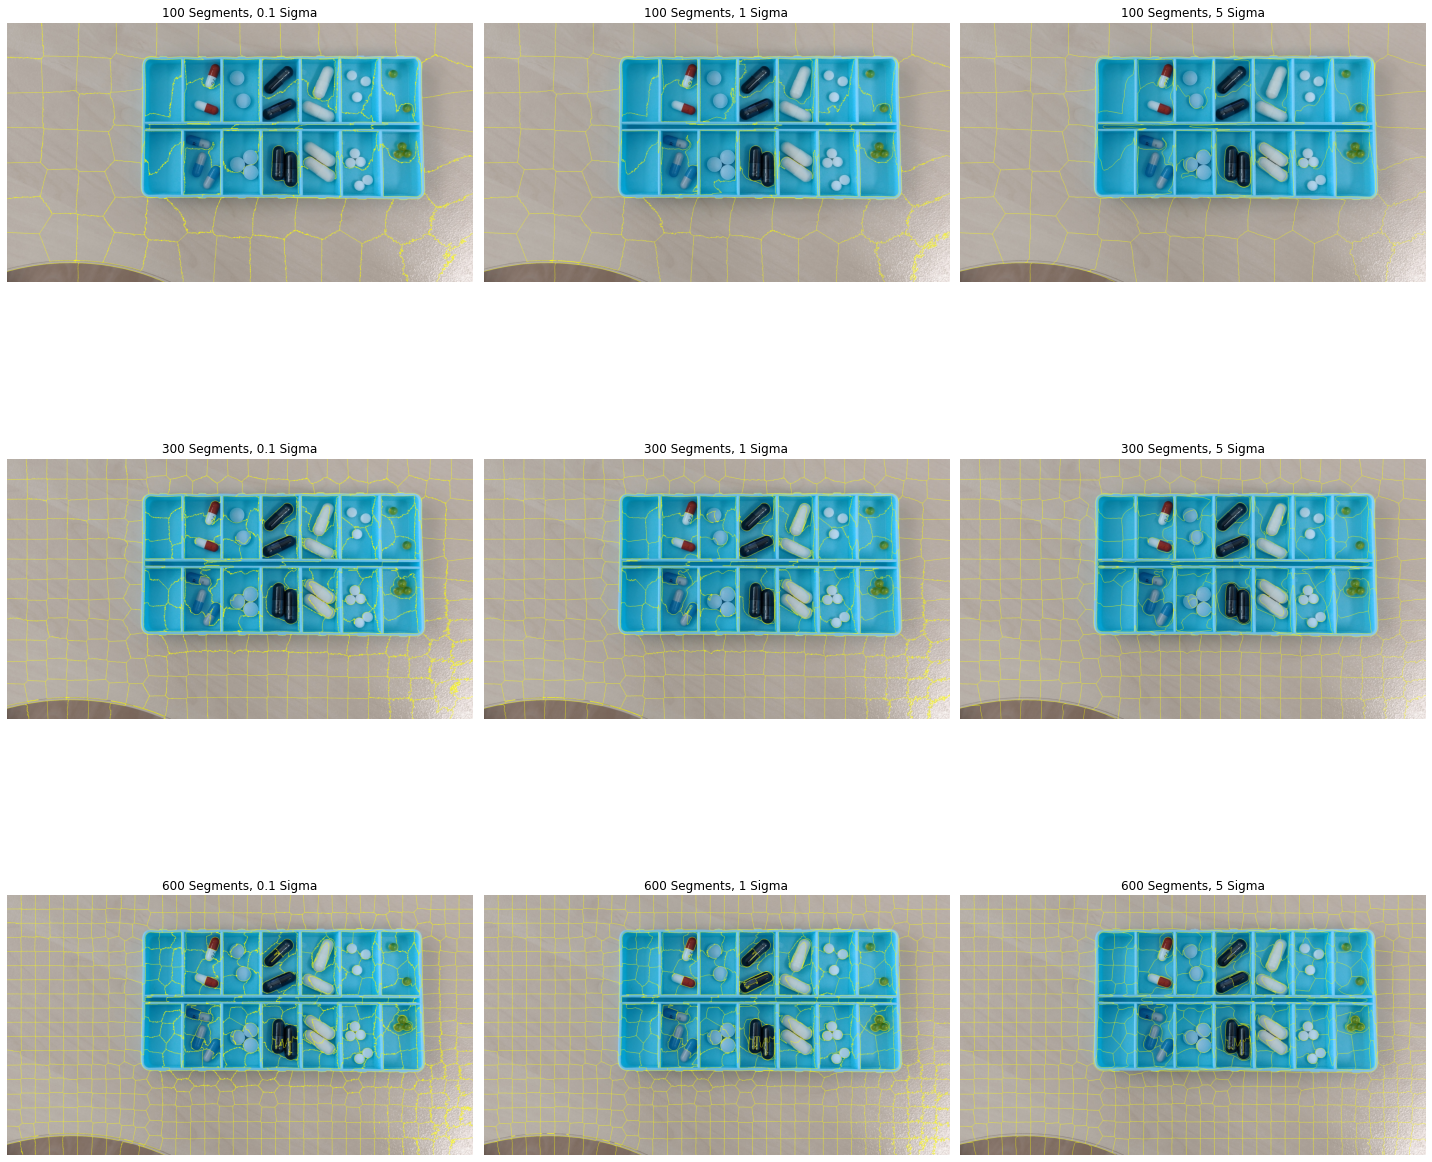

In [24]:
draw_test_segments(pills)

#### Zadanie 2

Dla obrazu `hare` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. `cv2.kmeans`) używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Zawsze możesz rozszerzyć rozwiązanie o bardziej wyrafinowane pomysły, jeśli starczy czasu.

Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [25]:
def get_mean_colors(img, segments):
    means = []
    for i in np.unique(segments):
        means.append(np.mean(img[segments == i], axis=0))
    return np.array(means, dtype=np.float32)

def prepare_superpixels(img, n_segments, sigma):
    segments = slic(hare, n_segments=n_segments, sigma=sigma, start_label=0)
    return segments, get_mean_colors(hare, segments)


In [26]:
def kmeans_superpixels(superpixels):
    _, labels, _ = cv2.kmeans(
        data=superpixels,
        K=2,
        bestLabels=None,
        criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
        attempts=10,
        flags=cv2.KMEANS_RANDOM_CENTERS 
    )

    # make sure that there are more 0 than 1 (aestetic reasons)
    if np.sum(labels == 0) < np.sum(labels == 1):
        labels = 1 - labels

    return labels


Możesz wykorzystać poniższy snippet by zredukować wynik segmentacji SLIC (`segments`) w oparciu o klasteryzację k-średnich (`labels`):

In [27]:
def postprocess_img(img, segments, labels):
    postprocessed = np.zeros_like(segments, dtype=np.uint8)
    for i, label in enumerate(labels):
        postprocessed[segments == i] = label * 255
    return postprocessed

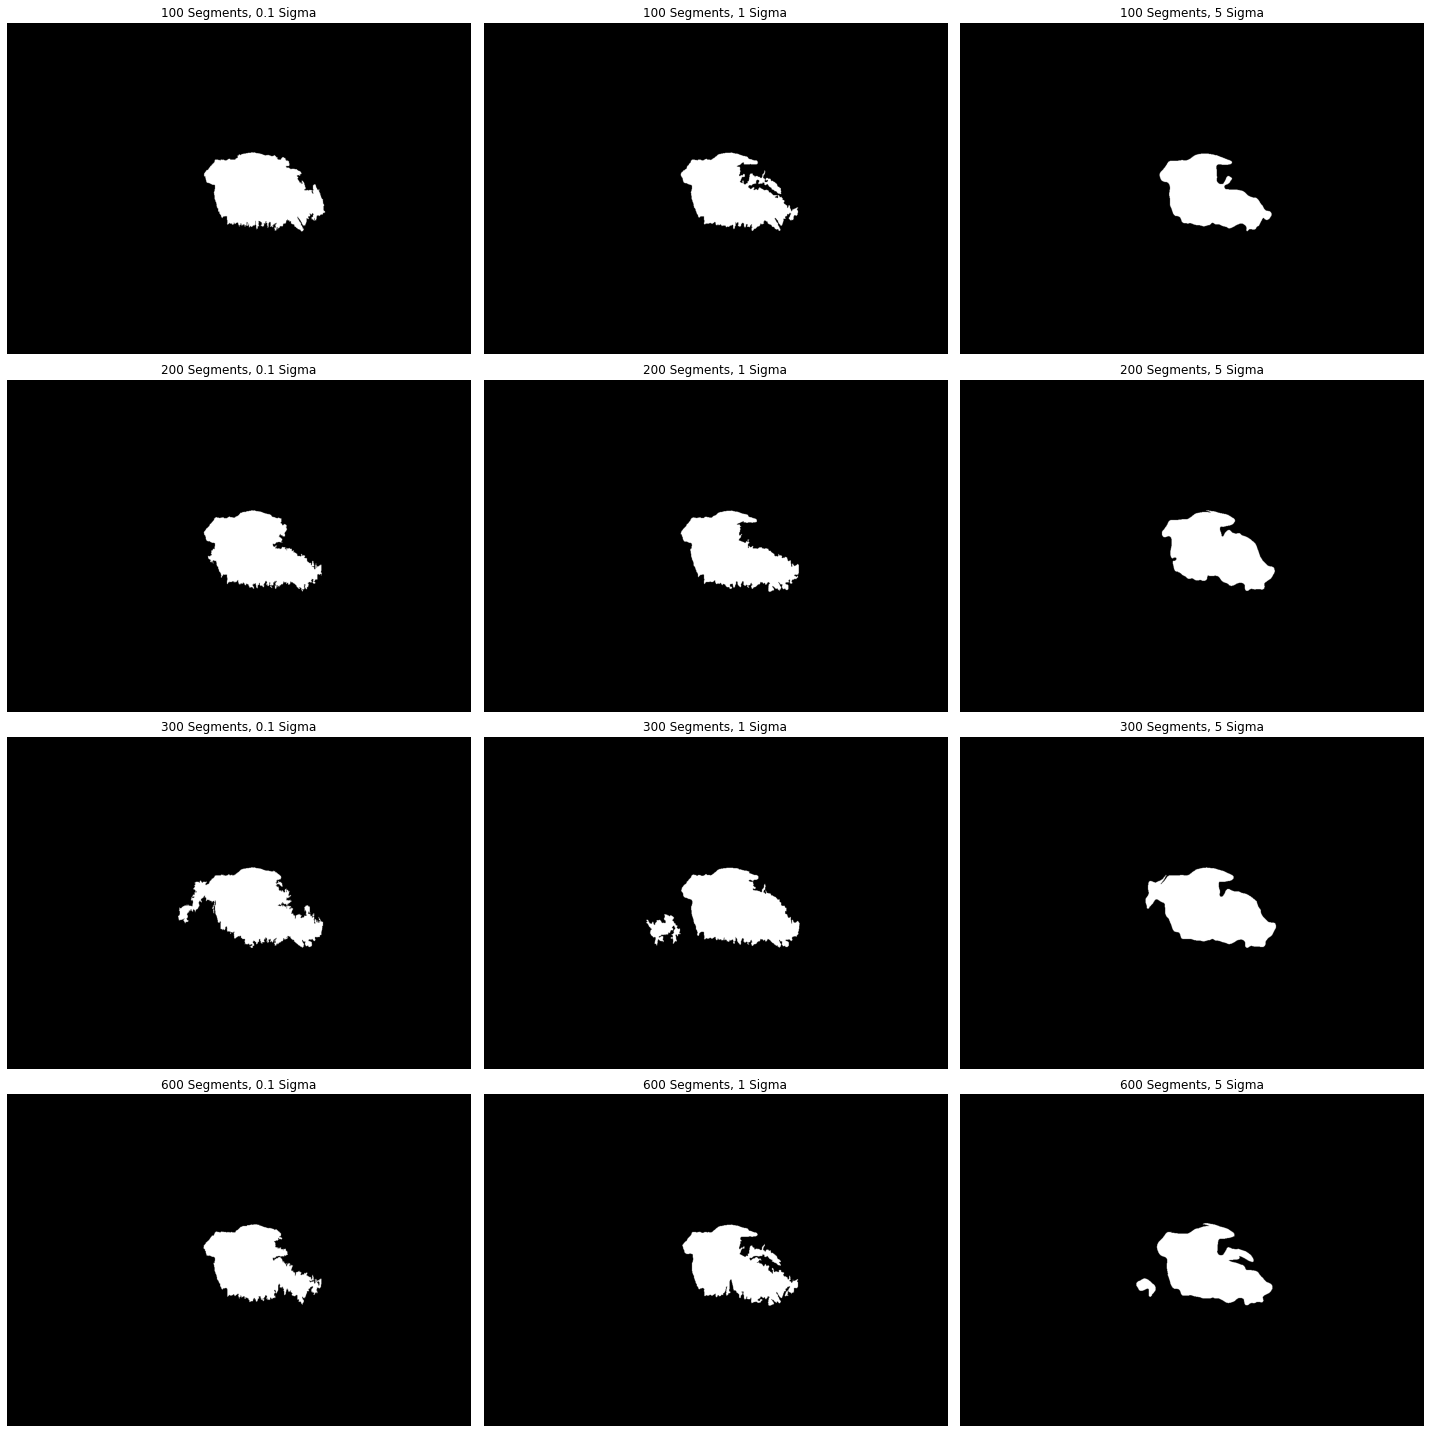

In [31]:
def segmentation(img, n_segments, sigma):
    segments, superpixels = prepare_superpixels(img, n_segments, sigma)
    labels = kmeans_superpixels(superpixels)
    return postprocess_img(img, segments, labels)

def plot_segmentation_grid(img, n_segments, sigmas):
    f, axs = plt.subplots(len(n_segments), len(sigmas), figsize=(20, 20))
    for row, numSegments in zip(axs, n_segments):
        for ax, sigma in zip(row, sigmas):
            segmented = segmentation(img, numSegments, sigma)
            ax.imshow(segmented, cmap='gray')
            ax.axis("off")
            ax.set_title(f'{numSegments} Segments, {sigma} Sigma')
    plt.tight_layout()
    plt.show()

plot_segmentation_grid(hare, [100, 200, 300, 600], [0.1, 1, 5])